Mount Drive & Main Imports

Apologies - In the code, the labels are written as healthy, low-level and mid-level, but these translate to healthy, early-stage and mid-stage in the report.

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import os
import re
from abc import ABC, abstractmethod
import random
import pandas as pd
random.seed(42)
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
import numpy as np
from skimage.measure import regionprops, label

# Setting up Paths:

PATH = "/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/"
IMG_PATH = PATH + "All_Leaves/"
BG_PATH = PATH + "background images"

In [ ]:
# To delete files in directories
 
# dir = PATH + 'YOLOv5/images/val'
# for f in tqdm(os.listdir(dir)):
#     os.remove(os.path.join(dir, f))

Importing the relevent functions

In [ ]:
os.chdir("/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/Extra_Modules")
from Cutter import Cutter
from ImageTransformer import ImageTranslator, ImageRotator, ImageReflector, Transformer
from utils import getImageFn, getMaskFn, drawBox, writeBBoxesIntoTxtFile
from BoundingBox import BoundingBox
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
from google.colab.patches import cv2_imshow 


In [ ]:
# Counting no. of images in Leaves Dataset
_, _, files = next(os.walk(IMG_PATH))
t_leaf_count = len(files)
t_leaf_count

15000

#Preprocessing

In [ ]:
labels = ["healthy", 
          "low_level_infection", 
          "mid_level_infection",]

In [ ]:
def getLabelWithSubstring(substring, df, labels, mapping):
  count = 0
  for i in df['Label'].unique():
    
    if substring in labels[i]:
      count += 1
      if substring.lower() not in mapping:
        mapping[substring.lower()] = []
      mapping[substring.lower()].append(i)
      print(i, labels[i])
  print()
  print("A total of: ", count, "labels")
  

In [ ]:
os.chdir(PATH)
!pwd
df = pd.read_csv("new_disease_large.csv")

/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks


In [ ]:
df

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
14995,14996,2
14996,14997,2
14997,14998,2
14998,14999,2


In [ ]:
images_src_array = []


for image in range(t_leaf_count):
  leaf_image_src = str(IMG_PATH+ str(image+1)+'.png')
  images_src_array.append(leaf_image_src)

df['Images_src'] = images_src_array # Figure out a more time efficeint way to do this... Actually, only takes ages to display...


In [ ]:
images_src_array[:10]

['/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/1.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/2.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/3.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/4.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/5.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/6.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/7.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/8.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/9.png',
 '/content/gdrive/MyDrive/Leaves_Project/Colab_Notebooks/All_Leaves/10.png']

In [ ]:
df[:5]

,ID,Label,Images_src
0,1,0,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1,2,0,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
2,3,0,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
3,4,0,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
4,5,0,/content/gdrive/MyDrive/Leaves_Project/Colab_N...


In [ ]:
mapping = {} # making a dictionary 'mapping' which gets filled with all the labels (healthy, low-level Infection, ...)
df['Label'].nunique()

3

In [ ]:
getLabelWithSubstring("healthy", df, labels, mapping)

0 healthy

A total of:  1 labels


In [ ]:
getLabelWithSubstring("low_level_infection", df, labels, mapping)

1 low_level_infection

A total of:  1 labels


In [ ]:
getLabelWithSubstring("mid_level_infection", df, labels, mapping)

2 mid_level_infection

A total of:  1 labels


In [ ]:
# getLabelWithSubstring("high_level_infection", df, labels, mapping)

In [ ]:
mapping
cat2Code = {'healthy':0, 'low_level_infection':1, 'mid_level_infection':2}

def convert2Code(x):
  for key, val in mapping.items():
    if x in val:
      return cat2Code[key]
  return None

def convert2Label(x):
  for key, val in cat2Code.items():
    if x == val:
      return key
  return None

In [ ]:
df['Label'] = df['Label'].apply(lambda x : convert2Code(x))
df['Label'] = df['Label'].apply(lambda x : convert2Label(x))


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

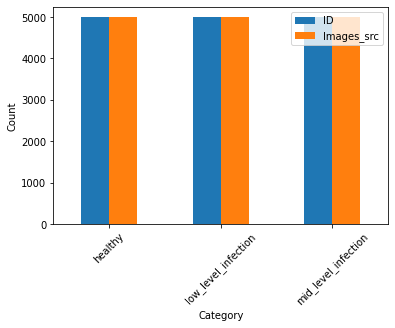

In [ ]:
df.groupby('Label').count().plot.bar()
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)

In [ ]:
healthy = df[df['Label']=='healthy']
l_l_inf = df[df['Label']=='low_level_infection']
m_l_inf =  df[df['Label']=='mid_level_infection']

In [ ]:
healthy

,ID,Label,Images_src
0,1,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1,2,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
2,3,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
3,4,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
4,5,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
...,...,...,...
4994,4995,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
4995,4996,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
4996,4997,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
4997,4998,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...


# Splitting Data

In [ ]:
def split(df, testFrac):
  idx = np.arange(0, len(df))
  # print(len(df))
  stp = len(df)-int(testFrac*len(df))
  # print(stp)
  np.random.shuffle(idx)
  trainIdx, testIdx = idx[:stp], idx[stp:]
  return df.iloc[trainIdx], df.iloc[testIdx]

In [ ]:
def shuffle(df):
  return df.sample(frac=1.0).reset_index(drop=True)

In [ ]:
healthy_train, healthy_test = split(healthy, 0.3)
l_l_inf_train, l_l_inf_test = split(l_l_inf, 0.3)
m_l_inf_train, m_l_inf_test = split(m_l_inf, 0.3)


In [ ]:
m_l_inf_train

,ID,Label,Images_src
11777,11778,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
12762,12763,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
13839,13840,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
12134,12135,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
11665,11666,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
...,...,...,...
12742,12743,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
11283,11284,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
11398,11399,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
14142,14143,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...


In [ ]:
healthy_test, healthy_valid = split(healthy_test, 0.5)
l_l_inf_test, l_l_inf_valid = split(l_l_inf_test, 0.5)
m_l_inf_test, m_l_inf_valid = split(m_l_inf_test, 0.5)

In [ ]:
trainDf = shuffle(pd.concat([healthy_train, l_l_inf_train, m_l_inf_train]).reset_index(drop=True))
validDf = pd.concat([healthy_valid, l_l_inf_valid, m_l_inf_valid]).reset_index(drop=True)
testDf = pd.concat([healthy_test, l_l_inf_test, m_l_inf_test]).reset_index(drop=True)


In [ ]:
validDf

,ID,Label,Images_src
0,2792,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
1,3666,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
2,2900,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
3,2425,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
4,1236,healthy,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
...,...,...,...
2244,13249,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
2245,11723,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
2246,10593,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...
2247,10397,mid_level_infection,/content/gdrive/MyDrive/Leaves_Project/Colab_N...


# Image Processing #
Remove background and add bounding box

In [ ]:
def kmeans_foreground(frame, thres=30):
  K = 2
  
  Z = frame.reshape((-1,3))
  Z = np.float32(Z)  

  # define criteria, number of clusters(K) and apply kmeans
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret,lbl,center=cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

  center = np.uint8(center)
  res = center[lbl.flatten()]
  res2 = res.reshape((frame.shape))

  # darker centroid  
  c = center.sum(axis=1).argmin(axis=0)
  r = tuple([thres]*3)
  mask = cv2.inRange(res2, center[c] - r, center[c] + r)
  return mask

def otsu_foreground(frame, getBright=False, gaussianFilterSize=5):
  n = gaussianFilterSize
  blurred = cv2.GaussianBlur(frame,(n,n),0)
  ret3,th3 = cv2.threshold(blurred.astype("uint8"),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  if getBright:
    return cv2.bitwise_not(th3)
  return th3

def fill_hole_in_binary_mask(mask):
  '''Fills in a closed contour within the binary mask'''

  des = mask.copy()
  contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contour:
    cv2.drawContours(des,[cnt],0,255,-1)
  return des

def apply_mask(frame, mask):
  return cv2.bitwise_and(frame, frame, mask=mask.astype("uint8"))

In [ ]:
class ImageAligner:
    def __init__(self, masked_item, mask):
        self.masked_item = masked_item
        self.mask = mask

    def alignImage(self):
        rp = max(regionprops(self.mask), key=lambda x: x.area)
        y, x = rp.centroid
        dy = H / 2 - y
        dx = W / 2 - x
        imgTransl = ImageTranslator(dx, dy)
        return imgTransl.transform(self.masked_item, self.mask)

In [ ]:
def writeBBoxesIntoTxtFile(bboxes, savePath, fn, label):
    with open(savePath+str(fn)+".txt", "w") as f:
        for ix, bb in enumerate(bboxes):
            line = "" if ix == len(bboxes) - 1 else "\n"
            s = str(cat2Code[label]) + " " + str(bb) + line
            f.write(s)

In [ ]:
class ImageAligner:
    def __init__(self, masked_item, mask):
        self.masked_item = masked_item
        self.mask = mask

    def alignImage(self):
        rp = max(regionprops(self.mask), key=lambda x: x.area)
        y, x = rp.centroid
        dy = H / 2 - y
        dx = W / 2 - x
        imgTransl = ImageTranslator(dx, dy)
        return imgTransl.transform(self.masked_item, self.mask)

In [ ]:
def pad_im(im, top, bottom, left, right):
  if len(im.shape)==3:
    return np.pad(im, ((top, bottom), (left, right), (0, 0)), 'constant')
  return np.pad(im, ((top, bottom), (left, right)))

def calculate_padding(bgim, mask, factor=2):
  total_height_diff = bgim.shape[0] - mask.shape[0]
  total_width_diff = bgim.shape[1] - mask.shape[1]

  vert_half = int(total_height_diff/factor)
  hori_half = int(total_width_diff/factor)

  top, bottom = vert_half, vert_half
  left, right = hori_half, hori_half
  
  bottom += total_height_diff%factor
  right += total_width_diff%factor

  return top, bottom, left, right

In [ ]:
FACTOR = 4

In [ ]:
class ImageTransformer(ABC):
    @abstractmethod
    def transform(self, img, mask):
        pass

class ImageTranslator(ImageTransformer):
    def __init__(self, tx, ty):
        self.tx = tx
        self.ty = ty
        self.matrix = None

    def transform(self, masked_item, mask, image):
        self.matrix = np.float32([[1, 0, self.tx], [0, 1, self.ty]])
        t_mask = cv2.warpAffine(mask, self.matrix, (mask.shape[1], mask.shape[0]))
        t_masked_item = cv2.warpAffine(masked_item, self.matrix, (masked_item.shape[1], masked_item.shape[0]))
        t_image = cv2.warpAffine(image, self.matrix, (image.shape[1], image.shape[0]))
        return t_mask, t_masked_item, t_image


In [ ]:
# Some Translator shifts to pick from
shifts_x = [(-100, -300), (-10, 10), (-300, -50), (100, 300), (200, 600), (300, 600)]
shifts_y = [(-300, -190), (-150, 0), (-10, 10), (100, 150), (250, 380)]

fn = os.listdir(BG_PATH)[0]
bgim = plt.imread(BG_PATH+"/" + fn)
temps = [plt.imread(BG_PATH+"/"+fn) for fn in os.listdir(BG_PATH)]

bgims = []
for bg in temps:
  bgims.append(bg)

# Randomising the background the leaf is placed on
bgims_idx = np.random.randint(0, len(bgims))
bgim = bgims[bgims_idx]

In [ ]:
DIM = (128, 128)
# BG_DIM = (1024, 1024)

def load_imgs_from(filenames, path, size=DIM):
  imgs = []
  for fn in tqdm(filenames):
    imgs.append(cv2.resize(plt.imread(path+fn), DIM))
  return imgs

In [ ]:
H, W = 270, 380
# Wrap all the methods into a single function
def foreground_separation(frame_lab, frame_rgb): 

  l, a, b = cv2.split(frame_lab)

  # Separating objects
  kmeans_rgb_mask = kmeans_foreground(frame_rgb).astype('bool')
  otsu_a_mask = otsu_foreground(a, True).astype('bool')
  otsu_b_mask = otsu_foreground(b, False).astype('bool')

  # Making masking criterions
  A = np.logical_and(kmeans_rgb_mask, otsu_a_mask)
  B = np.logical_and(kmeans_rgb_mask, otsu_b_mask)
  C = np.logical_or(otsu_a_mask, otsu_b_mask)

  # Correcting the mask by filling up any holes ( closed contours)
  corrected_mask =  fill_hole_in_binary_mask(np.uint8(A|B|C))

  return corrected_mask

In [ ]:
# Bounding box
colourCode = {'healthy':(80, 208, 255), # Light blue
              'low_level_infection': (255, 224, 32), # light yellow
              'mid_level_infection':(255, 160, 16),} # orange

def drawBox(img, bb, label="healthy"):
    FONT = cv2.FONT_HERSHEY_PLAIN
    x1, y1, x2, y2 = bb.x1, bb.y1, bb.x2, bb.y2
    cv2.rectangle(img, (x1, y1), (x2, y2), colourCode[label], 1)
    cv2.putText(img, label, (x1-15, y2 + 10), FONT, 0.7, colourCode[label], 1)

In [ ]:
class Patcher:
    def __init__(self, background):
        self.mask = None
        self.maskedItem = None
        self.background = background.copy()
        self.cache_background = background.copy()

    def resetBackground(self):
        self.background = self.cache_background

    def addMaskAndMaskedImage(self, mask, maskedItem):
        self.mask = mask
        self.maskedItem = maskedItem

    def patchImageToBackground(self):
        counter_mask = ~self.mask.astype("bool")
        # overlay bg with counter mask
        bg_hole = cv2.bitwise_and(self.background, self.background, mask=counter_mask.astype('uint8'))

        # overlay masked item onto bg (with hole)
        if self.maskedItem.shape[2] > 3:
            self.background = bg_hole + self.maskedItem[:, :, :bg_hole.shape[2]]
            return self.background
        self.background = bg_hole + self.maskedItem
        return self.background


# Image Augmentation, Relocation for YOLO training and Annotation v1
**Makes the dataset WITH BACKGROUND - These weren't used for training in the end. The next version without the background was used.**

This iterates through all the images in all_leaves dir, removes background , puts bounding box around and creates the txt file of the bounding box and label information for the later YOLO training.

Takes approx 50 mins for 1500 images.

Takes approx 7hrs for 15000 images.

In [ ]:
for i in tqdm(range(t_leaf_count)):
  bbs = []
  image = cv2.imread(IMG_PATH + str(i+1) + '.png')
  frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  frame_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  

  corrected_mask = foreground_separation(frame_lab, frame_rgb)
  corrected_masked_im = apply_mask(frame_rgb, corrected_mask)

  # Randomising the background the leaf is placed on
  bgims_idx = np.random.randint(0, len(bgims))
  bgim = bgims[bgims_idx]
  
  # padding
  padded_image = pad_im(image, *calculate_padding(bgim, corrected_mask, FACTOR))
  padded_mask = pad_im(corrected_mask, *calculate_padding(bgim, corrected_mask, FACTOR))
  padded_masked_im = pad_im(corrected_masked_im, *calculate_padding(bgim, corrected_masked_im, FACTOR))

  # resize
  final_image = cv2.resize(padded_image, (bgim.shape[1], bgim.shape[0]))
  final_mask = cv2.resize(padded_mask, (bgim.shape[1], bgim.shape[0]))
  final_masked_im = cv2.resize(padded_masked_im, (bgim.shape[1], bgim.shape[0]))

  # Translate the image
  s_x = random.sample(shifts_x, 1)
  s_y = random.sample(shifts_y, 1)
  # print(f"s_x: {s_x}")

  translator = ImageTranslator(tx=random.random()*s_x[0][0], ty=random.random()*s_y[0][0])
  t_mask, t_masked_im, t_image= translator.transform(final_masked_im, final_mask, final_image)


  rp = sorted(regionprops(label(t_mask.astype("bool"))),
            key=lambda r: r.area,
            reverse=True,)
  full_im = np.asarray(t_masked_im) # was image before
  h, w = full_im.shape[:2]

  y2, x1, y1, x2 = rp[0].bbox
  bbMask = BoundingBox.fromYOLOFormat(0.5 * (x1 + x2) / w, 0.5 * (y1 + y2) / h, abs(x1 - x2) / w,
                                    abs(y1 - y2) / h, t_mask)

  bbMask.convertToOriginalScale()
  bbs.append(bbMask)

  # Remaking the images with the smaller synthetic images overlayed onto the random backgrounds, then saved.

  t_image = cv2.cvtColor(t_image, cv2.COLOR_BGR2RGB)
  img = Image.fromarray(t_image)
  img = img.convert("RGBA")

  pixdata = img.load()

  width, height = img.size
  for y in range(height):
      for x in range(width):
          if pixdata[x, y] == (0, 0, 0, 255):
              pixdata[x, y] = (255, 255, 255, 0) # Making the smaller images with black background transparent.

  bgim = Image.fromarray(bgim)
  bgim.paste(img, (0, 0), img)
  
  t_masked_im_copy = np.asarray(t_masked_im.copy())
  # new_Bgim_copy = np.asarray(newBgim.copy())


  if i+1 in list(trainDf['ID'].values):
    ind_label = trainDf.loc[trainDf['ID'] == i+1, 'Label'].iloc[0]
    drawBox(img=t_masked_im_copy, bb=bbMask, label=ind_label)
    save_path_label = PATH + 'YOLOv5/labels/train/'
    save_path_image = PATH + 'YOLOv5/images/train/'
    print('train')
  elif i+1 in list(testDf['ID'].values):
    ind_label = testDf.loc[testDf['ID'] == i+1, 'Label'].iloc[0]
    drawBox(img=t_masked_im_copy, bb=bbMask, label=ind_label)
    save_path_label = PATH + 'YOLOv5/labels/test/'
    save_path_image = PATH + 'YOLOv5/images/test/'
    print('test')
  else:
    ind_label = validDf.loc[validDf['ID'] == i+1, 'Label'].iloc[0]
    drawBox(img=t_masked_im_copy, bb=bbMask, label=ind_label)
    save_path_label = PATH + 'YOLOv5/labels/val/'
    save_path_image = PATH + 'YOLOv5/images/val/'
    print('valid')

  # cv2_imshow(t_masked_im_copy)
  bgim.save(save_path_image + str(i+9932) + '.png')

  writeBBoxesIntoTxtFile(bbs, save_path_label, i+1 , ind_label)
  # plt.imsave(save_path_image + str(i+1) + '.png', newBgim)


Output hidden; open in https://colab.research.google.com to view.

# Image Augmentation, Relocation for YOLO training and Annotation v2
**This was the dataset used in the end! Removing the background resulted in much better detection on real videos than the previous dataset.**

This iterates through all the images in all_leaves dir, removes background , puts bounding box around and creates the txt file of the bounding box and label information for the later YOLO training.

Takes approx 8.5hrs for 15000 images.



In [ ]:
for i in tqdm(range(t_leaf_count)):
  bbs = []
  image = cv2.imread(IMG_PATH + str(i+1) + '.png')
  frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  frame_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  

  corrected_mask = foreground_separation(frame_lab, frame_rgb)
  corrected_masked_im = apply_mask(frame_rgb, corrected_mask)

  # Randomising the background the leaf is placed on
  bgims_idx = np.random.randint(0, len(bgims))
  bgim = bgims[bgims_idx]
  
  # padding
  padded_image = pad_im(image, *calculate_padding(bgim, corrected_mask, FACTOR))
  padded_mask = pad_im(corrected_mask, *calculate_padding(bgim, corrected_mask, FACTOR))
  padded_masked_im = pad_im(corrected_masked_im, *calculate_padding(bgim, corrected_masked_im, FACTOR))

  # resize
  final_image = cv2.resize(padded_image, (bgim.shape[1], bgim.shape[0]))
  final_mask = cv2.resize(padded_mask, (bgim.shape[1], bgim.shape[0]))
  final_masked_im = cv2.resize(padded_masked_im, (bgim.shape[1], bgim.shape[0]))

  # Translate the image
  s_x = random.sample(shifts_x, 1)
  s_y = random.sample(shifts_y, 1)
  # print(f"s_x: {s_x}")

  translator = ImageTranslator(tx=random.random()*s_x[0][0], ty=random.random()*s_y[0][0])
  t_mask, t_masked_im, t_image= translator.transform(final_masked_im, final_mask, final_image)


  rp = sorted(regionprops(label(t_mask.astype("bool"))),
            key=lambda r: r.area,
            reverse=True,)
  full_im = np.asarray(t_masked_im) # was image before
  h, w = full_im.shape[:2]

  y2, x1, y1, x2 = rp[0].bbox
  bbMask = BoundingBox.fromYOLOFormat(0.5 * (x1 + x2) / w, 0.5 * (y1 + y2) / h, abs(x1 - x2) / w,
                                    abs(y1 - y2) / h, t_mask)

  bbMask.convertToOriginalScale()
  bbs.append(bbMask)

  # Remaking the images with the smaller synthetic images overlayed onto the random backgrounds, then saved.
  # Background removed.

  patcher = Patcher(bgim)
  patcher.addMaskAndMaskedImage(mask=t_mask, maskedItem=t_masked_im)
  newBgim = patcher.patchImageToBackground()
  newBgim = Image.fromarray(newBgim)



  if i+1 in list(trainDf['ID'].values):
    ind_label = trainDf.loc[trainDf['ID'] == i+1, 'Label'].iloc[0]
    drawBox(img=t_masked_im_copy, bb=bbMask, label=ind_label)
    save_path_label = PATH + 'YOLOv5_nobackground/labels/train/'
    save_path_image = PATH + 'YOLOv5_nobackground/images/train/'
    print('train')
  elif i+1 in list(testDf['ID'].values):
    ind_label = testDf.loc[testDf['ID'] == i+1, 'Label'].iloc[0]
    drawBox(img=t_masked_im_copy, bb=bbMask, label=ind_label)
    save_path_label = PATH + 'YOLOv5_nobackground/labels/test/'
    save_path_image = PATH + 'YOLOv5_nobackground/images/test/'
    print('test')
  else:
    ind_label = validDf.loc[validDf['ID'] == i+1, 'Label'].iloc[0]
    drawBox(img=t_masked_im_copy, bb=bbMask, label=ind_label)
    save_path_label = PATH + 'YOLOv5_nobackground/labels/val/'
    save_path_image = PATH + 'YOLOv5_nobackground/images/val/'
    print('valid')

  # cv2_imshow(t_masked_im_copy)
  # cv2.imwrite(save_path_image + str(i+1) + '.png', newBgim)
  newBgim.save(save_path_image + str(i+1) + '.png')

  writeBBoxesIntoTxtFile(bbs, save_path_label, i+1 , ind_label)
  # plt.imsave(save_path_image + str(i+1) + '.png', newBgim)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("done! Head over to the yolov5 notebook for training.")